# 1. Environment setup

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from utility_dot_py.utility import QueryProcessor
from assistments_workbench.data_access.db_access.connector import db
from assistments_workbench.data_access.attach_query_result import attach_query_result_by_header
from assistments_workbench.config_reader import config
from assistments_workbench.data_converters.PFAConverter import PFAConverter
from assistments_workbench.models.model import classification_model

In [2]:
# make images show up and large for presentation
%matplotlib inline
pylab.rcParams['figure.figsize'] = 9, 6
pylab.rcParams['font.size'] = 14

In [3]:
# define output folder
output_dir = config.get('localfiles', 'data_path')

# 2. Run a SQL query and save results to a local file

This is the SQL query for getting user id, problem id, problem set id, and correctness from ASSISTments database

In [4]:
sql_query = """ select user_id, sequence_id, problem_id, correct from problem_logs pl
left join class_assignments ca on ca.id = pl.assignment_id
where ca.sequence_id in (
5968,11898,6921,5969,37570
) and pl.start_time >= '2015-01-01' and pl.start_time < '2015-12-01' and pl.correct is not null
and pl.original = 1
order by user_id, pl.id; """

Initialize then run the query processor: 

In [5]:
processor = QueryProcessor(db, output_dir)

In [6]:
sql_data_path = processor.run_query_to_csv(sql_query)

Running queries:   select user_id, sequence_id, problem_id, correct from problem_logs pl
left join class_assignments ca on ca.id = pl.assignment_id
where ca.sequence_id in (
5968,11898,6921,5969,37570
) and pl.start_time >= '2015-01-01' and pl.start_time < '2015-12-01' and pl.correct is not null
and pl.original = 1
order by user_id, pl.id; 


In [7]:
print sql_data_path

C:\Workarea\Data\query_result_2016_04_03_22_15_48.csv


# 3. Attach additional features to the data set (without writing SQL yourself)

Based on what we already have, automatically attach additional features to the data set, for exmaple, adding new _problem difficutly_ information to the data set becuase we have _problem id_.

In [8]:
sql_with_features = attach_query_result_by_header(sql_data_path)

contained header:  [('problem_id',)]
new header:  ['user_id', 'sequence_id', 'problem_id', 'correct', 'problem_difficulty']
Running queries to attach new information ...

In [9]:
print sql_with_features

C:\Workarea\Data\query_result_2016_04_03_22_15_48_w_feature.csv


# 4. Convert the data set to the PFA feature set

In [10]:
col_mapping = {'user_id': 0, 'sequence_id' : 1, 'problem_id' : 2, 'correct': 3, 'difficulty': 4}

In [11]:
pfa_data_path = PFAConverter(sql_with_features, None, col_mapping, 1)

In [12]:
print pfa_data_path

C:\Workarea\Data\query_result_2016_04_03_22_15_48_w_feature_pfa.csv


# 5. Data exploration

In [13]:
input_data = pd.read_csv(pfa_data_path)

Show first few row of the data set:

In [14]:
input_data.head()

,correct,skill_id,user_id,difficulty,11898_corr,37570_corr,5968_corr,5969_corr,6921_corr,11898_incorr,37570_incorr,5968_incorr,5969_incorr,6921_incorr
0,0,37570,62430,0.256757,0,0,0,0,0,0,0,0,0,0
1,1,37570,62430,0.243151,0,0,0,0,0,0,1,0,0,0
2,0,37570,62432,0.219753,0,0,0,0,0,0,0,0,0,0
3,0,37570,62432,0.306499,0,0,0,0,0,0,1,0,0,0
4,1,37570,62432,0.356808,0,0,0,0,0,0,2,0,0,0


Show basic data statistics:

In [15]:
input_data.describe()

,correct,skill_id,user_id,difficulty,11898_corr,37570_corr,5968_corr,5969_corr,6921_corr,11898_incorr,37570_incorr,5968_incorr,5969_incorr,6921_incorr
count,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000
mean,0.714209,16406.593545,297223.101703,0.352117,0.631697,1.057125,0.452822,0.343734,0.452438,0.244151,0.977181,0.424802,0.433759,0.263636
std,0.451793,13473.382428,47352.835096,0.133383,1.953845,3.332289,1.616981,1.340692,1.926643,1.252751,3.629067,1.751206,1.694989,1.291671
min,0.000000,5968.000000,62430.000000,0.078431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5969.000000,278745.000000,0.247028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,11898.000000,302917.000000,0.340573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,37570.000000,337236.000000,0.433304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,37570.000000,362271.000000,0.956907,31.000000,48.000000,24.000000,25.000000,35.000000,36.000000,62.000000,39.000000,29.000000,25.000000


In [16]:
# mean of probelm difficulty
np.mean(input_data['difficulty'])

0.3521166764424559

# 6. Data visualization

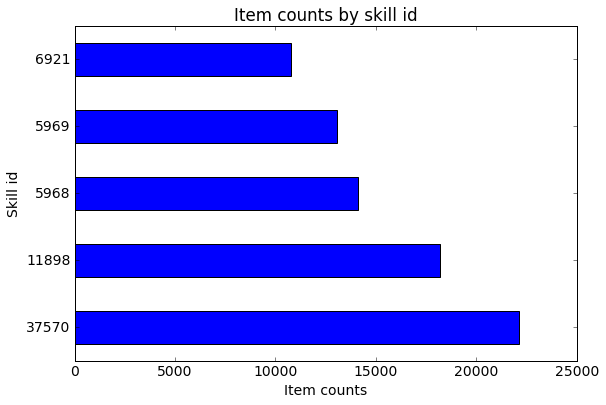

In [17]:
input_data.skill_id.value_counts().plot(kind='barh')
plt.title('Item counts by skill id')
plt.xlabel('Item counts')
plt.ylabel('Skill id')

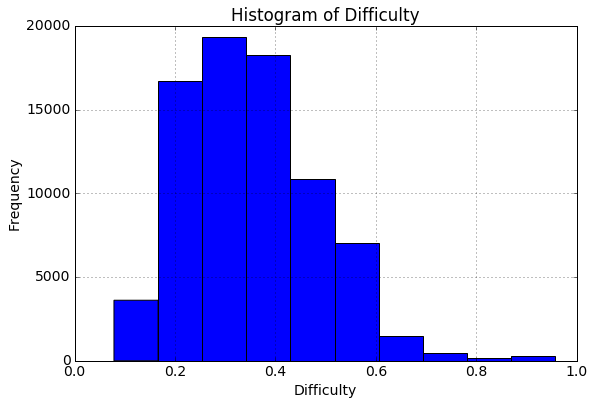

In [18]:
# hisogtam of difficulty
input_data['difficulty'].hist()
plt.title('Histogram of Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Frequency')

# 7. Feature engineering
Add z-socre of difficulty as a new feature:

In [19]:
input_data['z_difficulty'] = stats.zscore(input_data['difficulty'])

Add the ration of all correct and incorrect resposnes as a new feature: 

In [20]:
input_data['correct_ration'] = (input_data['11898_corr'] + input_data['37570_corr'] + input_data['5968_corr'] +
input_data['5969_corr'] + input_data['6921_corr']) / (input_data['11898_incorr'] + input_data['37570_incorr'] + 
    input_data['5968_incorr'] + input_data['6921_incorr'] +input_data['5969_incorr'] + 1)

In [21]:
input_data.describe()

,correct,skill_id,user_id,difficulty,11898_corr,37570_corr,5968_corr,5969_corr,6921_corr,11898_incorr,37570_incorr,5968_incorr,5969_incorr,6921_incorr,z_difficulty,correct_ration
count,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,78267.000000,7.826700e+04,78267.000000
mean,0.714209,16406.593545,297223.101703,0.352117,0.631697,1.057125,0.452822,0.343734,0.452438,0.244151,0.977181,0.424802,0.433759,0.263636,-2.193949e-15,1.084225
std,0.451793,13473.382428,47352.835096,0.133383,1.953845,3.332289,1.616981,1.340692,1.926643,1.252751,3.629067,1.751206,1.694989,1.291671,1.000006e+00,1.325427
min,0.000000,5968.000000,62430.000000,0.078431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.051894e+00,0.000000
25%,0.000000,5969.000000,278745.000000,0.247028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.878806e-01,0.083333
50%,1.000000,11898.000000,302917.000000,0.340573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.654943e-02,0.833333
75%,1.000000,37570.000000,337236.000000,0.433304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.086857e-01,1.500000
max,1.000000,37570.000000,362271.000000,0.956907,31.000000,48.000000,24.000000,25.000000,35.000000,36.000000,62.000000,39.000000,29.000000,25.000000,4.534283e+00,19.000000


# 8. Run LogisticRegression and DecisionTreeClassifier on the data set

In [22]:
all_features = input_data.columns.tolist()
print all_features

['correct', 'skill_id', 'user_id', 'difficulty', '11898_corr', '37570_corr', '5968_corr', '5969_corr', '6921_corr', '11898_incorr', '37570_incorr', '5968_incorr', '5969_incorr', '6921_incorr', 'z_difficulty', 'correct_ration']


Remove _correct_ and _user id_ from feature set and label _skill id_ as a categorical feature.  

In [23]:
label = 'correct'
all_features.remove(label)
all_features.remove('user_id')
predictors = all_features
categorical_features = ['skill_id']

Run 5-fold logistic regression to predict _correct_ with all features.

In [24]:
model = LogisticRegression()
classification_model(model, input_data, predictors, label, categorical_features, 5)

Predictors: ['skill_id', 'difficulty', '11898_corr', '37570_corr', '5968_corr', '5969_corr', '6921_corr', '11898_incorr', '37570_incorr', '5968_incorr', '5969_incorr', '6921_incorr', 'z_difficulty', 'correct_ration']
auc: 0.728323343286
r2: 0.132616619217
rmse: 0.420793634175
accuracy: 0.732377606976


Run 5-fold decision tree to predict _correct_ with all features.

In [25]:
model = DecisionTreeClassifier()
classification_model(model, input_data, predictors, label, categorical_features, 5)

Predictors: ['skill_id', 'difficulty', '11898_corr', '37570_corr', '5968_corr', '5969_corr', '6921_corr', '11898_incorr', '37570_incorr', '5968_incorr', '5969_incorr', '6921_incorr', 'z_difficulty', 'correct_ration']
auc: 0.624691479633
r2: 0.0443036425152
rmse: 0.500891443501
accuracy: 0.678612959638
